In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from scipy.integrate import cumtrapz

Populating the interactive namespace from numpy and matplotlib


In [2]:
def strain_components(a, t):
    # Returns xx, yy, xy components of strain given by eqn 38 
    x = array([cos(pi * t / 2.) ** 2,
               sin(pi * t / 2.) ** 2,
               sin(pi * t) / 2.])
    return a * t * x
    
def strain_rate_components(a, t):
    # Returns xx, yy, xy components of strain rate given by eqn 42
    x = array([1 + cos(pi * t) - pi * t * sin(pi * t),
               1 - cos(pi * t) + pi * t * sin(pi * t),
               pi * t * cos(pi * t) + sin(pi * t)])
    return a * x / 2.

def rate_of_deformation_components(a, t):
    # Returns xx, yy, xy components of rate of deformation given by eqn 44
    x = array([a + a * cos(pi * t) - pi * sin(pi * t) * sinh(a * t),
               a - a * cos(pi * t) + pi * sin(pi * t) * sinh(a * t),
               a * sin(pi * t) + pi * cos(pi * t) * sinh(a * t)])
    return x / 2.

In [3]:
a = .5
tf = 2.
N = 1000
d = zeros((N, 3))
eps = zeros((N, 3))
depsdt = zeros((N, 3))

time = linspace(0, tf, N)
for (i, t) in enumerate(time):
    eps[i] = strain_components(a, t)
    depsdt[i] = strain_rate_components(a, t)
    d[i] = rate_of_deformation_components(a, t)
int_d = row_stack(([0, 0, 0], cumtrapz(d, x=time, axis=0)))

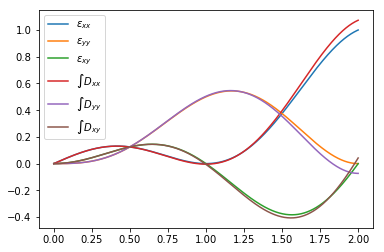

In [4]:
for (i, label) in enumerate(['xx', 'yy', 'xy']):
    plot(time, eps[:, i], label=r'$\epsilon_{%s}$'%label)
for (i, label) in enumerate(['xx', 'yy', 'xy']):
    plot(time, int_d[:, i], label=r'$\int D_{%s}$'%label)
legend(loc='upper left');

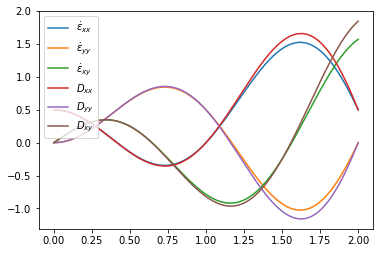

In [5]:
for (i, label) in enumerate(['xx', 'yy', 'xy']):
    plot(time, depsdt[:, i], label=r'$\dot{\epsilon}_{%s}$'%label)
for (i, label) in enumerate(['xx', 'yy', 'xy']):
    plot(time, d[:, i], label=r'$D_{%s}$'%label)
legend(loc='upper left');

## Tresca Verification

In [6]:
from pandas import DataFrame
from matmodlab2 import TrescaMaterial, MaterialPointSimulator

Setting up the Matmodlab notebook environment


negative Poisson's ratio


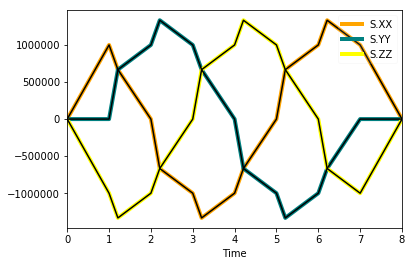

In [7]:
# Multi-step verification test
I3, Z3x3 = np.eye(3), np.zeros((3,3))
rt3 = np.sqrt(3.0)
kmod = 8.0
gmod = 1.0e9
ys = 1.0e6
fac = ys / (6.0 * gmod)
eta = (3.0 - rt3) / 6.0
stress = np.zeros((3,3))
table_head = ["Time", "E.XX", "E.YY", "E.ZZ", "S.XX", "S.YY", "S.ZZ"]
table_data = [
    # t          e1                 e2                e3        s1       s2       s3
    [0.0,                0.0,            0.0,            0.0,     0.0,     0.0,     0.0],
    [1.0,      fac*(3      ),  fac*(0      ), -fac*(3      ),      ys,     0.0,     -ys],
    [1.0+eta, -fac*(1-2*rt3),  fac*(2      ), -fac*(1+2*rt3),  2*ys/3,  2*ys/3, -4*ys/3],
    [2.0,     -fac*(3-2*rt3),  fac*(6+2*rt3), -fac*(3+4*rt3),     0.0,      ys,     -ys],
    [2.0+eta, -fac*(5-2*rt3),  fac*(4+4*rt3),  fac*(1-6*rt3), -2*ys/3,  4*ys/3, -2*ys/3],
    [3.0,     -fac*(9      ),  fac*(6+6*rt3),  fac*(3-6*rt3),     -ys,      ys,     0.0],
    [3.0+eta, -fac*(7+2*rt3),  fac*(2+8*rt3),  fac*(5-6*rt3), -4*ys/3,  2*ys/3,  2*ys/3],
    [4.0,     -fac*(9+4*rt3),  fac*(  8*rt3),  fac*(9-4*rt3),     -ys,     0.0,      ys],
    [4.0+eta, -fac*(5+6*rt3), -fac*(2-8*rt3),  fac*(7-2*rt3), -2*ys/3, -2*ys/3,  4*ys/3],
    [5.0,     -fac*(3+6*rt3), -fac*(6-6*rt3),  fac*(9      ),     0.0,     -ys,      ys],
    [5.0+eta, -fac*(1+6*rt3), -fac*(4-4*rt3),  fac*(5+2*rt3),  2*ys/3, -4*ys/3,  2*ys/3],
    [6.0,      fac*(3-4*rt3), -fac*(6-2*rt3),  fac*(3+2*rt3),      ys,     -ys,     0.0],
    [6.0+eta,  fac*(1-2*rt3), -fac*(2      ),  fac*(1+2*rt3),  4*ys/3, -2*ys/3, -2*ys/3],
    [7.0,      fac*(3      ), -fac*(0      ), -fac*(3      ),      ys,     0.0,     -ys],
    [8.0,                0.0,            0.0,            0.0,     0.0,     0.0,     0.0],
]

# Drive the TrescaModel using prescribed strain from the above table
N = 20
mps = MaterialPointSimulator('Tresca')
tresca = TrescaMaterial(K=kmod, G=gmod, A1=ys)
mps.material = tresca
for row in table_data[1:]:
    mps.run_step('EEE', row[1:4], frames=N, time_whole=row[0])

# Convert the analytical table to Pandas DataFrames
df_analytical = DataFrame(data=table_data, columns=table_head)

# Get results from simuation
data = array(mps.df[['Time', 'S.XX', 'S.YY', 'S.ZZ']])

# Plot the stresses, analytical dashed, simulated solid
fig, ax = subplots()
df_analytical.plot(x="Time", y=['S.XX', 'S.YY', 'S.ZZ'], ax=ax, lw=4,
                   color=['Orange', 'Teal', 'Yellow'])
ax.plot(data[:,0][::N], data[:,1][::N], 'k-', lw=1.5)
ax.plot(data[:,0][::N], data[:,2][::N], 'k-', lw=1.5)
ax.plot(data[:,0][::N], data[:,3][::N], 'k-', lw=1.5)
ax.legend(loc='best', fancybox=True, framealpha=0.1);